In [1]:
!pip install tqdm torchmetrics

In [21]:
import torch
import torch.nn as nn
from tqdm import trange
from torchmetrics.functional import accuracy


class ConvNet(nn.Module):
    def __init__(self, n):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, n, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(n, n*2, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(n*2, n*2, kernel_size=3, padding=0)
        self.relu3 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n*2 * 6 * 6, 64)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        return x

def model_parameter_count(m):
  return sum(p.numel() for p in m.parameters())

model = ConvNet(10)
print(model_parameter_count(model))
print(model)
for i in model.parameters():
    print(i.shape)

52514
ConvNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=720, out_features=64, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
torch.Size([10, 3, 3, 3])
torch.Size([10])
torch.Size([20, 10, 3, 3])
torch.Size([20])
torch.Size([20, 20, 3, 3])
torch.Size([20])
torch.Size([64, 720])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [46]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Check if GPU is available and set the device accordingly
assert torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define data transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified


In [47]:
for c in range(1, 21):
    model = ConvNet(c)
    print(f"c={c}, param={model_parameter_count(model)}")

c=1, param=5408
c=2, param=10210
c=3, param=15120
c=4, param=20138
c=5, param=25264
c=6, param=30498
c=7, param=35840
c=8, param=41290
c=9, param=46848
c=10, param=52514
c=11, param=58288
c=12, param=64170
c=13, param=70160
c=14, param=76258
c=15, param=82464
c=16, param=88778
c=17, param=95200
c=18, param=101730
c=19, param=108368
c=20, param=115114


Now that we have defined a neural network, let's train it to convergence. To save time, we use AdamW optimizer and the OneCycle learning rate schedule. The OneCycle scheduler needs calibration, however.

channel count = 1


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.72s/it]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.15E-02


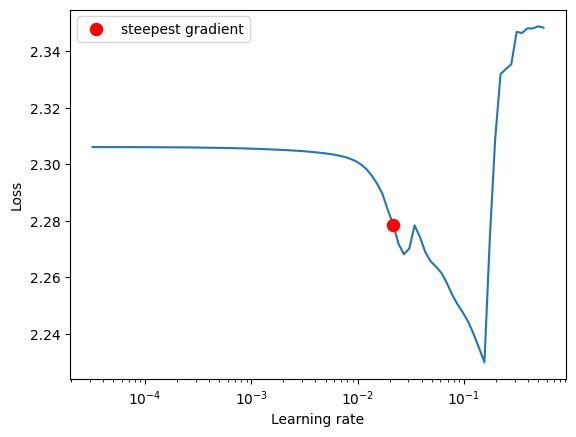

channel count = 5


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:00<00:00,  1.81s/it]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.56E-03


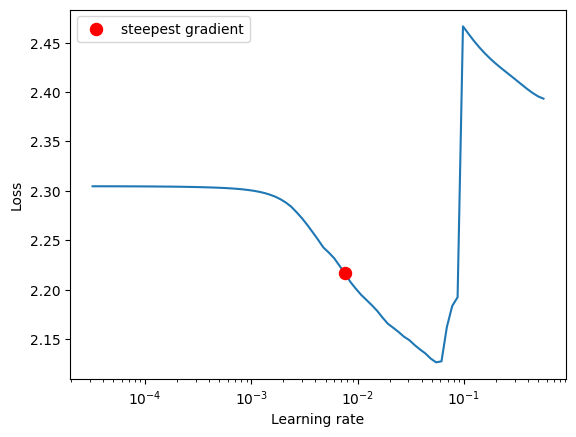

channel count = 10


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:17<00:00,  1.97s/it]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.71E-02


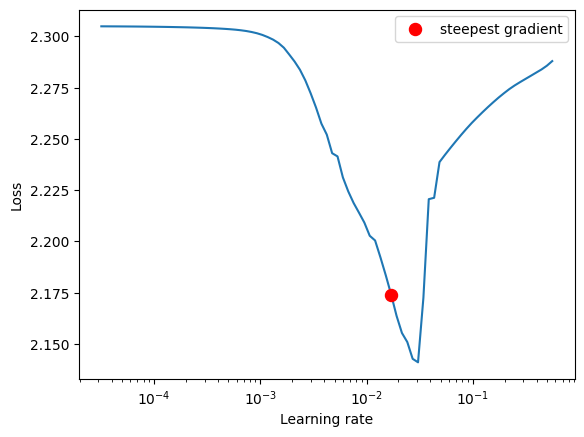

channel count = 15


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:40<00:00,  2.20s/it]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.99E-03


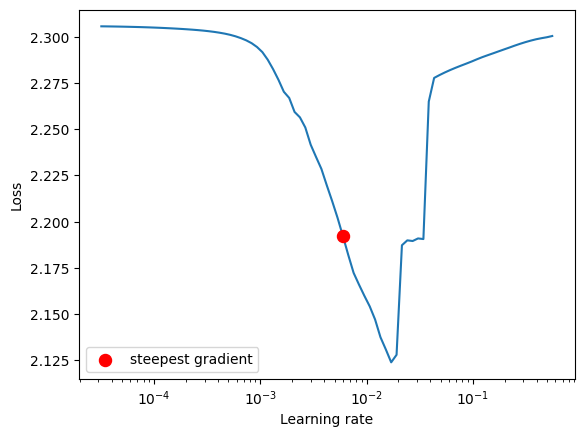

channel count = 20


 91%|██████████████████████████████████████████████████████████████████████████▌       | 91/100 [03:37<00:21,  2.39s/it]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.38E-01


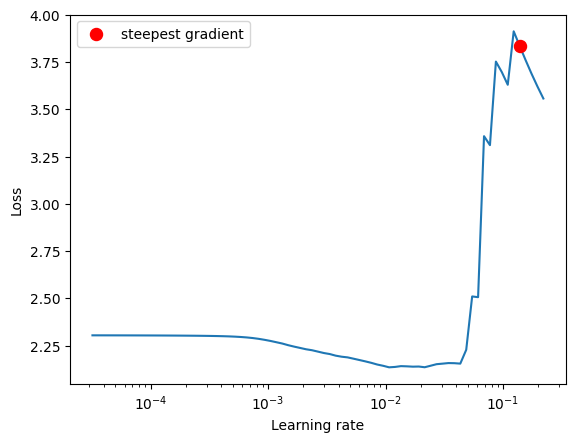

In [82]:
from torch_lr_finder import LRFinder

for channel_count in [1, 5, 10, 15, 20]:
    print(f"channel count = {channel_count}")
    model = ConvNet(channel_count)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters())
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_loader, val_loader=val_loader, start_lr=1e-5, end_lr=1, num_iter=100)
    lr_finder.plot()
    lr_finder.reset()

channel count = 20


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:52<00:00,  2.33s/it]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.56E-03


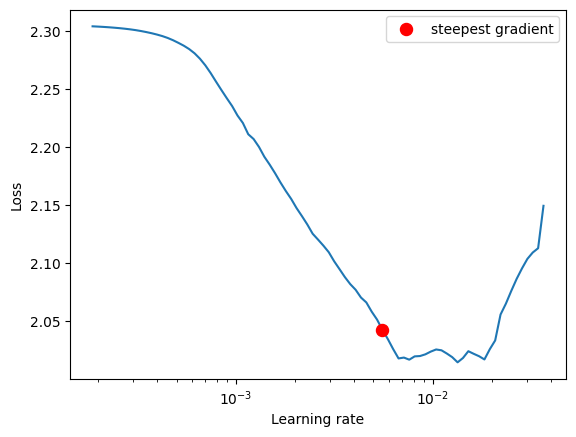

In [83]:
channel_count = 20

print(f"channel count = {channel_count}")
model = ConvNet(channel_count)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=val_loader, start_lr=1e-4, end_lr=0.05, num_iter=100)
lr_finder.plot()
lr_finder.reset()

In [86]:
from torchmetrics.classification import Accuracy
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torch.optim.lr_scheduler import OneCycleLR

channel_count = 20
model = ConvNet(channel_count)
print(f"Model has parameter count {model_parameter_count(model)}")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

# Create the OneCycleLR scheduler and attach it to the optimizer
min_lr, max_lr = 1e-4, (100 / model_parameter_count(model))
scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    final_div_factor=max_lr/min_lr,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader)
)

num_epochs = 50

# Training loop
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []
progress_bar = trange(num_epochs)

metric = Accuracy(task="multiclass", num_classes=10).to(device)
metric.reset()

experiment_name = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
writer = SummaryWriter(f'logs/n_{channel_count}/lr_{max_lr:.2e}_{experiment_name}')

metadata = {
    'Channel count': channel_count,
    'Model size': model_parameter_count(model),
    'Epochs': num_epochs,
}

for key, value in metadata.items():
    writer.add_text(key, str(value))

for epoch in progress_bar:
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        metric(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

    writer.add_scalar('Loss/Train', running_loss / len(train_loader), epoch)
    train_losses.append(running_loss / len(train_loader))
    writer.add_scalar('Accuracy/Train', metric.compute().item(), epoch)
    train_accuracy.append(metric.compute().item())
    metric.reset()

    # Calculate validation loss at the end of each epoch
    model.eval()
    val_correct = 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            val_loss += criterion(outputs, labels).item()
            metric(outputs, labels)

    writer.add_scalar('Loss/Validation', val_loss / len(val_loader), epoch)
    val_losses.append(val_loss / len(val_loader))
    writer.add_scalar('Accuracy/Validation', metric.compute().item(), epoch)
    val_accuracy.append(metric.compute().item())
    metric.reset()

progress_bar.close()
writer.close()

Model has parameter count 115114


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [10:43<00:00, 12.86s/it]


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(train_losses)
ax.plot(train_accuracy)
ax.plot(val_losses)
ax.plot(val_accuracy)
plt.show()